### Key drivers that impact the evolution of the US central bank rate

Import Librairies

In [26]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.cluster import KMeans

FRED API parameters

In [3]:
api_url = "https://api.stlouisfed.org/fred/series/observations"
api_key = "fab85be8c9e01cc886af340ce19bb2fa"

In [69]:
economic_variables = {
    'fed_funds_rate': 'FEDFUNDS',
    'unemployment_rate': 'UNRATE',
    'inflation_rate': 'CPIAUCSL',
}

Here we define a function that allows us to extract data from FRED database

In [5]:
def get_fred_data(series_id, api_key, observation_start, file_type, frequency):
    params = {
        "series_id": series_id,
        "api_key": api_key,
        "observation_start": observation_start,
        "file_type": file_type,
        "frequency": frequency
    }

    response = requests.get(api_url, params=params)

    if response.status_code == 200:
        data = response.json()
        observations = data['observations']
        df=pd.DataFrame(observations)
        df.index = pd.to_datetime(df['date'])
        df.drop(columns=['realtime_start','realtime_end','date'],inplace=True)
        df.rename(columns={'value': series_id}, inplace=True)  
        return df
    else:
        return None


In [70]:
df = pd.DataFrame()
for i in economic_variables.values():
    print(i)    
    df = pd.concat([df, get_fred_data(i, api_key, "1960-01-01", "json", "m")], axis=1)
df

FEDFUNDS
UNRATE
CPIAUCSL


,FEDFUNDS,UNRATE,CPIAUCSL
date,,,
1960-01-01,3.99,5.2,29.37
1960-02-01,3.97,4.8,29.41
1960-03-01,3.84,5.4,29.41
1960-04-01,3.92,5.2,29.54
1960-05-01,3.85,5.1,29.57
...,...,...,...
2024-05-01,5.33,4.0,313.225
2024-06-01,5.33,4.1,313.049
2024-07-01,5.33,4.3,313.534


In [53]:
df['FEDFUNDS'] = df['FEDFUNDS'].astype(float)
df['UNRATE'] = df['UNRATE'].astype(float)
df['CPIAUCSL'] = df['CPIAUCSL'].astype(float) 


Evolution of Central Banks rates

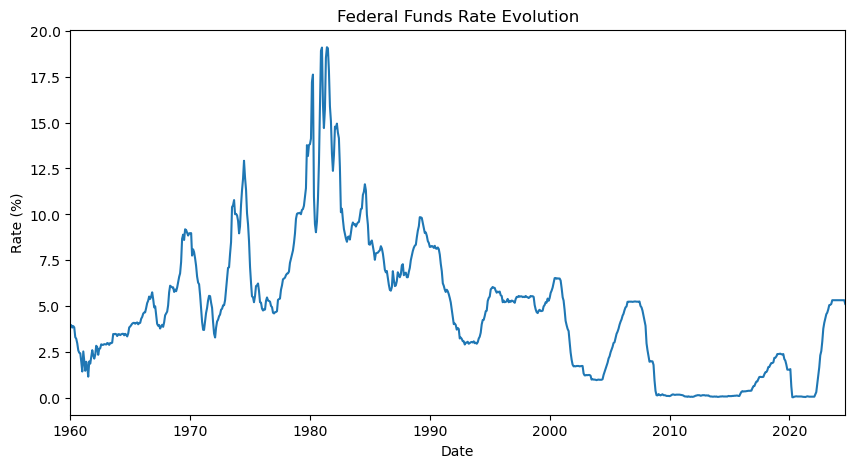

In [8]:
plt.figure(figsize=(10,5))
plt.plot(df['FEDFUNDS'])
plt.xlim(df.index.min(), df.index.max())
plt.title('Federal Funds Rate Evolution')
plt.ylabel('Rate (%)')
plt.xlabel('Date')  
plt.show()  

### 1) Unemployment rate

Let s plot an empirical relationship 

<Figure size 2000x500 with 0 Axes>

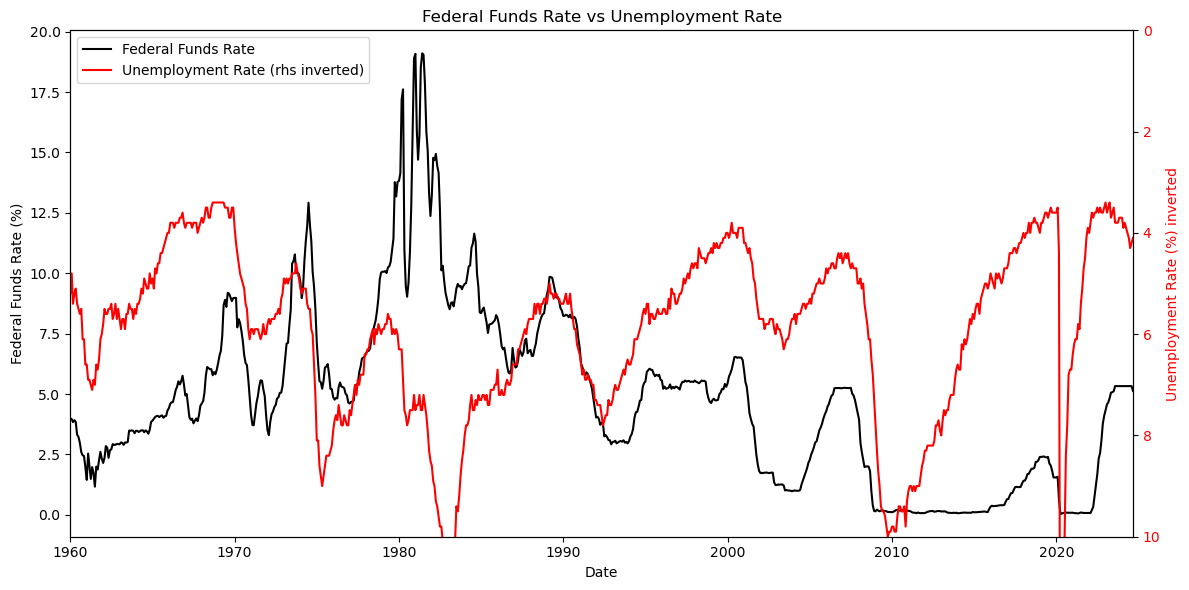

In [61]:

plt.figure(figsize=(20,5))
fig, ax1 = plt.subplots(figsize=(12, 6))


# Plot Federal Funds Rate on primary y-axis
line1, = ax1.plot(df.index, df['FEDFUNDS'], color='k', label='Federal Funds Rate')
ax1.set_xlabel('Date')
ax1.set_ylabel('Federal Funds Rate (%)', color='k')
ax1.tick_params(axis='y', labelcolor='k')
ax1.set_xlim(df.index.min(), df.index.max()) 

# Create secondary y-axis and plot Unemployment Rate
ax2 = ax1.twinx()
line2, = ax2.plot(df.index, df['UNRATE'], color='r', label='Unemployment Rate (rhs inverted)')
ax2.set_ylabel('Unemployment Rate (%) inverted', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.invert_yaxis()
ax2.set_ylim(10, 0)

# Add legends
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')
plt.title('Federal Funds Rate vs Unemployment Rate')

# Show the plot
fig.tight_layout()
plt.show()

c:\Users\33659\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\33659\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


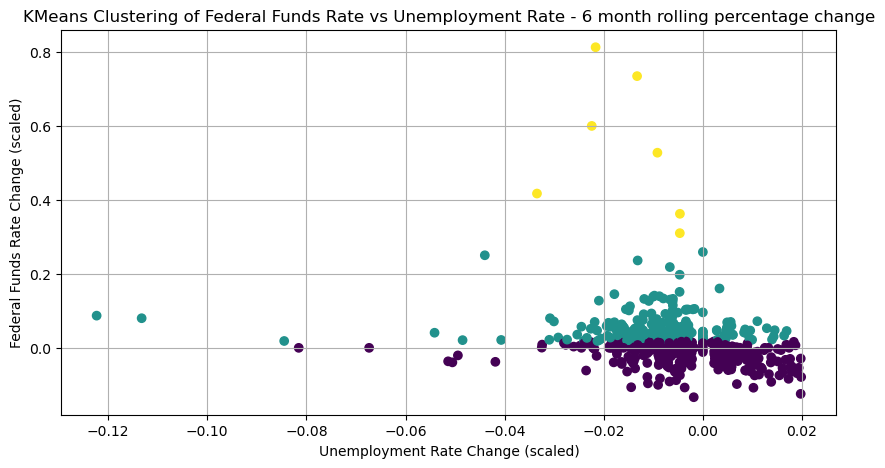

In [44]:
# Calculate 6-month rolling mean
rolling_mean = df[['UNRATE', 'FEDFUNDS']].rolling(window=6).mean()

# Calculate percentage change based on the rolling mean
rolling_pct_change = rolling_mean.pct_change().dropna()

# Filter out outliers where unemployment rate change is greater than 2% and not equal to 0
filtered_pct_change = rolling_pct_change[(rolling_pct_change['UNRATE'] <= 0.02) & (rolling_pct_change['UNRATE'] != 0)]

# Reshape the data for plotting
X = filtered_pct_change['UNRATE'].values.reshape(-1, 1)
y = filtered_pct_change['FEDFUNDS'].values.reshape(-1, 1)
data = np.hstack((X, y))

# Perform KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data)

# Get cluster labels
plt.figure(figsize=(10,5))
labels = kmeans.labels_
plt.scatter(X, y, c=labels, cmap='viridis')
plt.title('KMeans Clustering of Federal Funds Rate vs Unemployment Rate - 6 month rolling percentage change')
plt.xlabel('Unemployment Rate Change (scaled)')
plt.ylabel('Federal Funds Rate Change (scaled)')
plt.grid()
plt.show()


### 2. Inflation

<Figure size 2000x500 with 0 Axes>

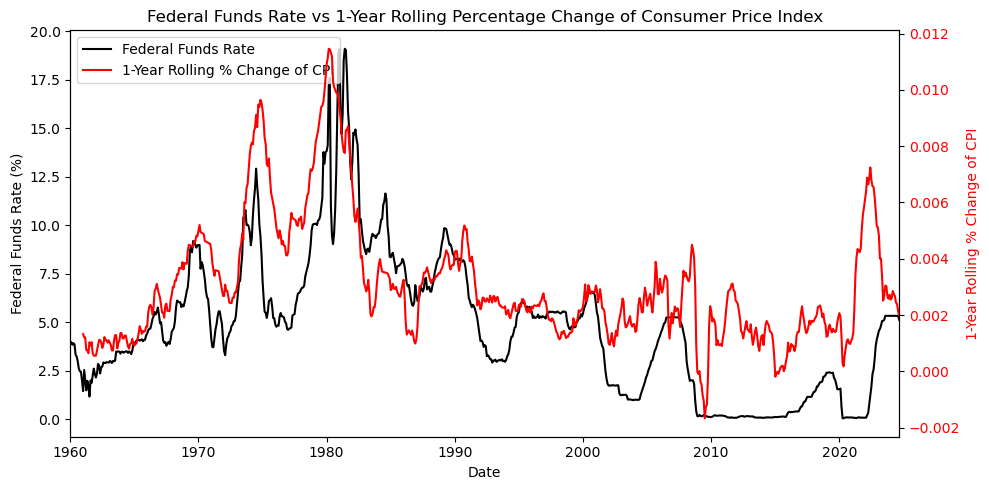

In [59]:

# Calculate percentage change based on the 1-year rolling mean
rolling_mean_cpi = df['CPIAUCSL'].rolling(window=12).mean()
rolling_pct_change_cpi = rolling_mean_cpi.pct_change().dropna()

# Plot Federal Funds Rate vs 1-year rolling percentage change of CPI
plt.figure(figsize=(20,5))
fig, ax1 = plt.subplots(figsize=(10, 5))  

# Plot Federal Funds Rate on primary y-axis
line1, = ax1.plot(df.index, df['FEDFUNDS'], color='k', label='Federal Funds Rate')
ax1.set_xlabel('Date')
ax1.set_ylabel('Federal Funds Rate (%)', color='k')
ax1.tick_params(axis='y', labelcolor='k')
ax1.set_xlim(df.index.min(), df.index.max()) 

# Create secondary y-axis and plot 1-year rolling percentage change of CPI
ax2 = ax1.twinx()
line2, = ax2.plot(rolling_pct_change_cpi.index, rolling_pct_change_cpi, color='r', label='1-Year Rolling % Change of CPI')
ax2.set_ylabel('1-Year Rolling % Change of CPI', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add legends
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')
plt.title('Federal Funds Rate vs 1-Year Rolling Percentage Change of Consumer Price Index')

# Show the plot
fig.tight_layout()
plt.show()

c:\Users\33659\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\33659\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


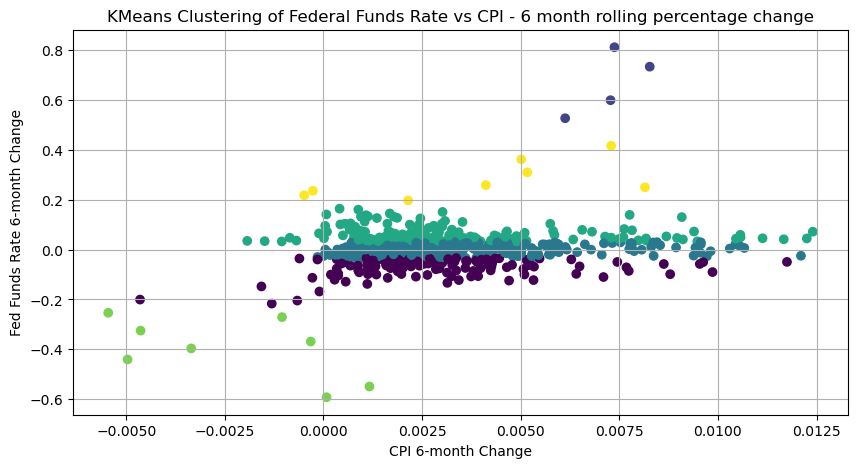

In [66]:
# Calculate 6-month rolling mean
rolling_mean = df[['CPIAUCSL', 'FEDFUNDS']].rolling(window=6).mean()

# Calculate percentage change based on the rolling mean
rolling_pct_change = rolling_mean.pct_change().dropna()

# Reshape the data for plotting
X = rolling_pct_change['CPIAUCSL'].values.reshape(-1, 1)
y = rolling_pct_change['FEDFUNDS'].values.reshape(-1, 1)
data = np.hstack((X, y))

# Perform KMeans clustering
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(data)

# Get cluster labels
plt.figure(figsize=(10,5))
labels = kmeans.labels_
plt.scatter(X, y, c=labels, cmap='viridis')
plt.title('KMeans Clustering of Federal Funds Rate vs CPI - 6 month rolling percentage change')
plt.xlabel('CPI 6-month Change')
plt.ylabel('Fed Funds Rate 6-month Change')
plt.grid()
plt.show()


Mean Squared Error: 0.006632681606596519
R-squared: 0.09880472210283309


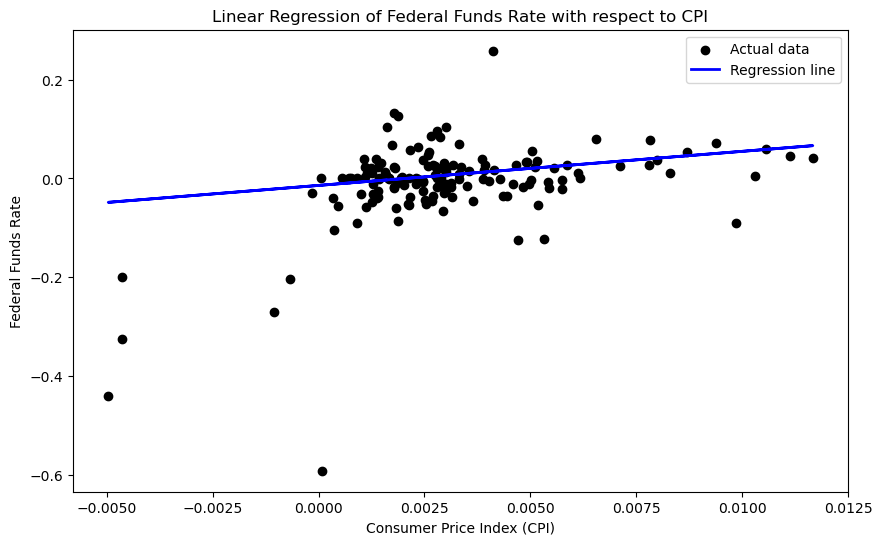

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Predict the Federal Funds Rate using the test data
y_pred = model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='black', label='Actual data')
plt.plot(X_test, y_pred, color='blue', linewidth=2, label='Regression line')
plt.xlabel('Consumer Price Index (CPI)')
plt.ylabel('Federal Funds Rate')
plt.title('Linear Regression of Federal Funds Rate with respect to CPI')
plt.legend()
plt.show()

### 3. Multiple Linear Regression

Mean Squared Error: 6.047288274249201
R-squared: 0.5315048039702643


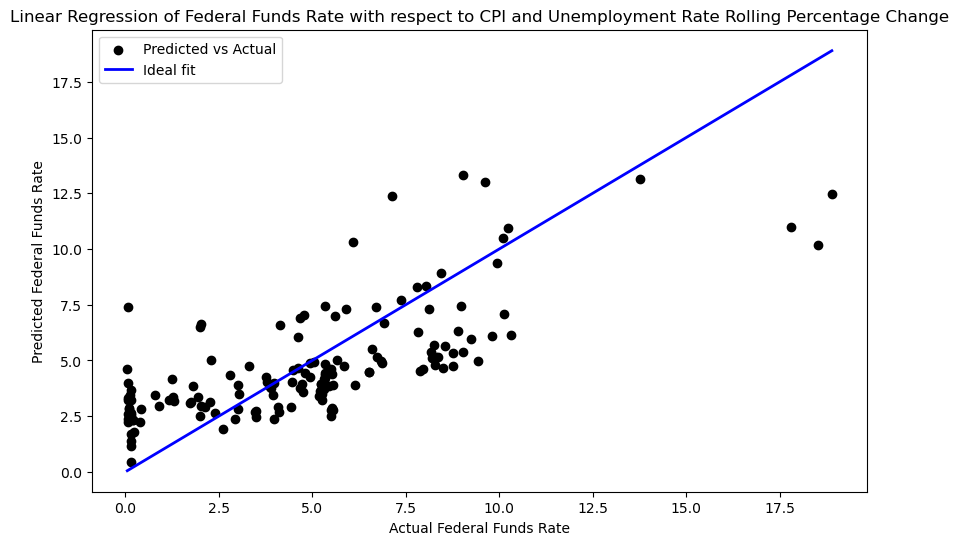

In [68]:
# Calculate 1-year rolling percentage change for CPI and UNRATE
rolling_mean_cpi = df['CPIAUCSL'].rolling(window=12).mean()
rolling_pct_change_cpi = rolling_mean_cpi.pct_change().dropna()

rolling_mean_unrate = df['UNRATE'].rolling(window=12).mean()
rolling_pct_change_unrate = rolling_mean_unrate.pct_change().dropna()

# Align the indices of the rolling percentage changes
rolling_pct_change_cpi = rolling_pct_change_cpi.reindex(df.index).dropna()
rolling_pct_change_unrate = rolling_pct_change_unrate.reindex(df.index).dropna()

# Combine the features into a single dataset
X = pd.concat([rolling_pct_change_cpi, rolling_pct_change_unrate], axis=1).dropna()
y = df.loc[X.index, 'FEDFUNDS']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Predict the Federal Funds Rate using the test data
y_pred = model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='black', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='blue', linewidth=2, label='Ideal fit')
plt.xlabel('Actual Federal Funds Rate')
plt.ylabel('Predicted Federal Funds Rate')
plt.title('Linear Regression of Federal Funds Rate with respect to CPI and Unemployment Rate Rolling Percentage Change')
plt.legend()
plt.show()